In [1]:
# Add module to path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# Imports
from aoc23.utils import read_input
import numpy as np
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt

In [3]:
input_18 = read_input(18)

## Part 1

In part 1 of the [day 18 puzzle](https://adventofcode.com/2023/day/18), we are given a list of instructions describing the boundary of a lagoon: each instruction contains a direction (`U`, `D`, `L` or `R`) as well as an integer giving the number of steps to move in that direction. By starting at some initial location (e.g. $(0, 0)$) and following the steps in sequence, we will eventually end up back at the starting position. The puzzle asks to find the number of integer lattice points contained inside the boundary, including points on the boundary itself.

First, extract the list of instructions from the input file:

In [4]:
def process_input(input_strings):
    steps = [[s.strip('()') for s in line.split()] for line in input_strings]
    return steps

In [5]:
steps = process_input(input_18)
steps[:5]

[['R', '8', '#594dc2'],
 ['U', '3', '#7deda3'],
 ['R', '9', '#594dc0'],
 ['U', '5', '#4ce433'],
 ['R', '3', '#5bbe72']]

Each instruction also contain a hexadecimal number, but this won't be needed until part 2, so let's ignore it for now. The example instructions from the puzzle will also come in useful, for testing the implementation:

In [6]:
test_input = [
    'R 6 (#70c710)',
    'D 5 (#0dc571)',
    'L 2 (#5713f0)',
    'D 2 (#d2c081)',
    'R 2 (#59c680)',
    'D 2 (#411b91)',
    'L 5 (#8ceee2)',
    'U 2 (#caa173)',
    'L 1 (#1b58a2)',
    'U 2 (#caa171)',
    'R 2 (#7807d2)',
    'U 3 (#a77fa3)',
    'L 2 (#015232)',
    'U 2 (#7a21e3)'
]

In [7]:
test_steps = process_input(test_input)

My first reaction to reading this puzzle was that it reminded me a lot of the puzzle from [day 10](_posts/2023-12-08-aoc23-day10.md), where we we asked to find the number of tiles inside an enclosing boundary, similarly made of consecutive tiles. The approach there involved looping over the rows in the array, checking each character one at a time and determining whether it lay inside or outside the boundary. However, I wanted to use a different approach this time (spoiler: it was worthwhile, in retrospect, after completing part 2!).

After some reflection, I remembered the following theorem by Georg Alexander Pick (1899):

> __Theorem 1:__ (Pick’s Theorem). Consider a simple polygon (i.e. no holes) with
vertices lying on an integer grid. The area, $A$, can be calculated using the following formula:
>
>$$
A = i + \frac{b}{2} − 1
$$
>
>where $i$ is the number of grid points inside the polygon, and $b$ is the
>number of grid points that lie on the boundary of the polygon.

Georg Alexander Pick was an interesting and influential mathematician - although he is now most commonly known by this theorem, he also made contributions to complex analysis and differential geometry. In fact, he was supposedly the person who introduced the work of Ricci-Curbastro and Levi-Civita on Ricci calculus to Albert Einstein, who used it as an essential component of his theory of general relativity.

In this specific setup, by considering the elements of the grid to lie on integer lattice points, Pick's theorem allows us to relate the number of points inside the boundary to the number on the boundary (easily computed from the steps directly) and the area. Thankfully, there is a further result which allows us to compute the area of the polygon created by the boundary, using just the coordinates of the vertices:

> __Theorem 2:__ (Shoelace formula). Consider a simple polygon (i.e. no holes) with vertices $(x_i, y_i)$ in Cartesian coordinates, for $1\le i\le n+1$ ($n$ vertices, and the $(n+1)$st vertex a copy of the first to complete the loop), arranged counter-clockwise around the boundary. Then the area of the region inside the polygon is given by the following formula:

$$
A = \frac{1}{2}\sum_{i=1}^{n+1}\begin{vmatrix}x_i & y_i \\ x_{i+1} & y_{i+1} \end{vmatrix}
$$

For a thorough explanation of this formula, an intuitive derivation and some applications, take a look at this [excellent video from Mathologer](https://www.youtube.com/watch?v=0KjG8Pg6LGk).

Now, let's get implementing - the first job is to create a list of the nodes forming the boundary of the polygon. This is easily done by iterating over the steps, and recording the coordinates of each node. During this process, the total length of the boundary can also be tracked - as each step is to a integer lattice point, the total length will be the quantity $b$ needed for Pick's theorem.

In [8]:
def compute_boundary(steps: list[list[str]]) -> tuple[list[tuple[int]], int]:
    # Initialise
    vertices = [(0, 0)]
    idx = (0, 0)
    
    # Also track the total boundary points
    n_boundary = 0
    
    for step in steps:
        direction, n = step[0], step[1]
        n = int(n)
        
        # Take steps in direction
        n_boundary += n
        if direction == 'R':
            idx = (idx[0], idx[1] + n)
        if direction == 'L':
            idx = (idx[0], idx[1] - n)
        if direction == 'D':
            idx = (idx[0] + n, idx[1])
        if direction == 'U':
            idx = (idx[0] - n, idx[1])
            
        vertices.append(idx)
    
    # Last vertex should be equal to first vertex, and is not needed
    assert vertices.pop() == vertices[0]
    
    return vertices, n_boundary

Note that the starting vertex of the boundary is chosen to be the origin $(0, 0)$. An interesting property of the shoelace formula is that it is translation invariant, i.e. independent of the place in the lattice where the polygon is located (as would be expected for the area), so the initial point is arbitrary.

From the vertices, the shoelace formula determines the area:

In [9]:
def shoelace_compute(vertices: list[tuple[int]]) -> int:
    area = 0
    
    # Loop over pairs of vertices around boundary
    for vertex_1, vertex_2 in zip(vertices, [*vertices[1:], vertices[0]]):
        area += vertex_1[0]*vertex_2[1] - vertex_1[1]*vertex_2[0]
    
    # Area will be negative if boundary is traversed clockwise
    return int(abs(area/2))

Let's test this out on the example instructions, provided by the puzzle. We are told to expect 38 boundary points:

In [10]:
test_vertices, test_n_boundary = compute_boundary(test_steps)
assert test_n_boundary == 38
print('Success!')
print(f'Vertices: {test_vertices}')

Success!
Vertices: [(0, 0), (0, 6), (5, 6), (5, 4), (7, 4), (7, 6), (9, 6), (9, 1), (7, 1), (7, 0), (5, 0), (5, 2), (2, 2), (2, 0)]


One final point to note is that we are asked to find the total number of points _including_ the boundary points, not just the interior points. Rearranging the formula from Pick's theorem, the total number of points $T$ is:

$$
\begin{align}
T &= \left(A + 1 - \frac{b}{2}\right) + b \\
&= A + 1 + \frac{b}{2}.
\end{align}
$$

Putting this together, we find that the total number of points inside/on the boundary is:

In [11]:
test_area = shoelace_compute(test_vertices)
print(test_area + 1 + int(test_n_boundary/2))

62


Just as expected! Applying this now to the full set of input instructions:

In [12]:
vertices, n_boundary = compute_boundary(steps)
area = shoelace_compute(vertices)
print(area + 1 + int(n_boundary/2))

74074


So the answer to part 1 is: __74074__.

This is what the resulting lagoon looks like for the full set of instructions:

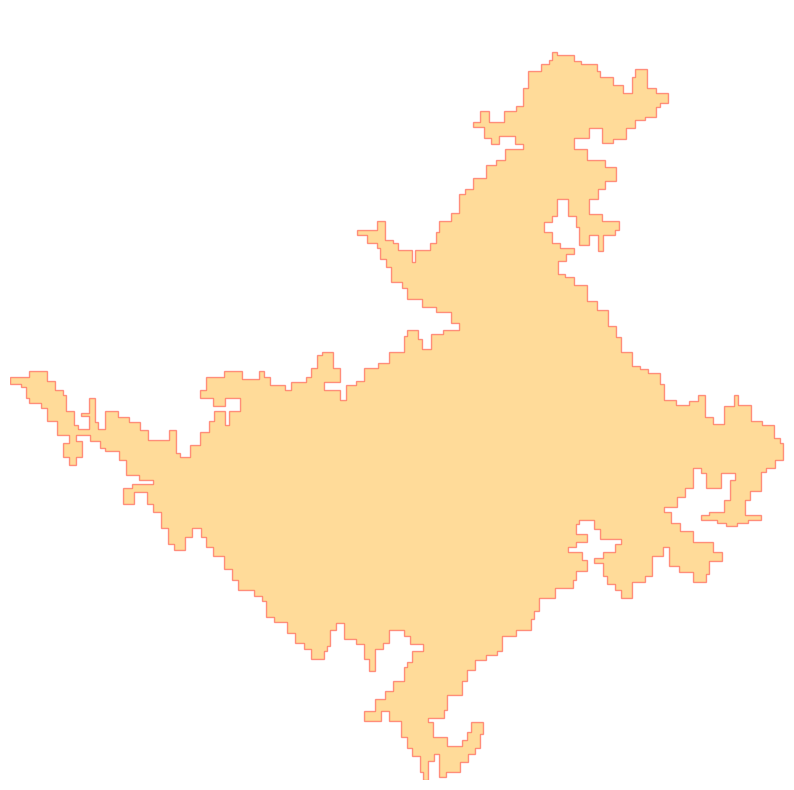

In [13]:
v = np.array(vertices)
mins = v.min(axis=0)
maxs = v.max(axis=0)
width = max(maxs - mins)

p = Polygon(v, facecolor = 'orange', alpha=0.4, edgecolor='r')

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor('b')
ax.add_patch(p)
ax.set_xlim([mins[0], mins[0] + width + 1])
ax.set_ylim([mins[1], mins[1] + width + 1])
ax.axis('off')
ax.set_facecolor('b')
plt.show()

## Part 2

In part 2, the hexadecimal colour codes in the instructions turn out not to be colours, but instead the true instructions that are meant to be followed: the first 5 characters are the numbers of steps to take, and the final character is a code determining the direction. The true instructions can be extracted into the more familiar form:

In [14]:
def convert_colour_to_step(colour_string: str) -> tuple[str, int]:
    direction, n = colour_string[-1], colour_string[1:-1]
    n = int(n, 16)
    direction = {
        '0': 'R',
        '1': 'D',
        '2': 'L',
        '3': 'U'
    }[direction]
    
    return direction, n

Consider again the test instructions provided by the puzzle:

In [15]:
test_new_steps = [convert_colour_to_step(step[2]) for step in test_steps]
print(test_new_steps[:5])

[('R', 461937), ('D', 56407), ('R', 356671), ('D', 863240), ('R', 367720)]


As can be seen here, the steps are much larger than in part 1 - clearly constructing and looping over an array is not the right approach, justifying using Pick's theorem and the shoelace formula (which depend only on the number of instructions, not on the size of the steps). We can check that we get the exected answer:

In [16]:
test_new_vertices, test_new_n_boundary = compute_boundary(test_new_steps)
test_new_area = shoelace_compute(test_new_vertices)
assert test_new_area + 1 + int(test_new_n_boundary/2) == 952408144115
print('Success!')

Success!


And so the applying the formulae for the final time to the full set of instructions:

In [17]:
new_steps = [convert_colour_to_step(step[2]) for step in steps]
new_vertices, new_n_boundary = compute_boundary(new_steps)
new_area = shoelace_compute(new_vertices)
print(new_area + 1 + int(new_n_boundary/2))

112074045986829


So the final answer to part 2 is: __112074045986829__.

Just for fun, here is a visualization of the lagoon defined by the new set of instructions:

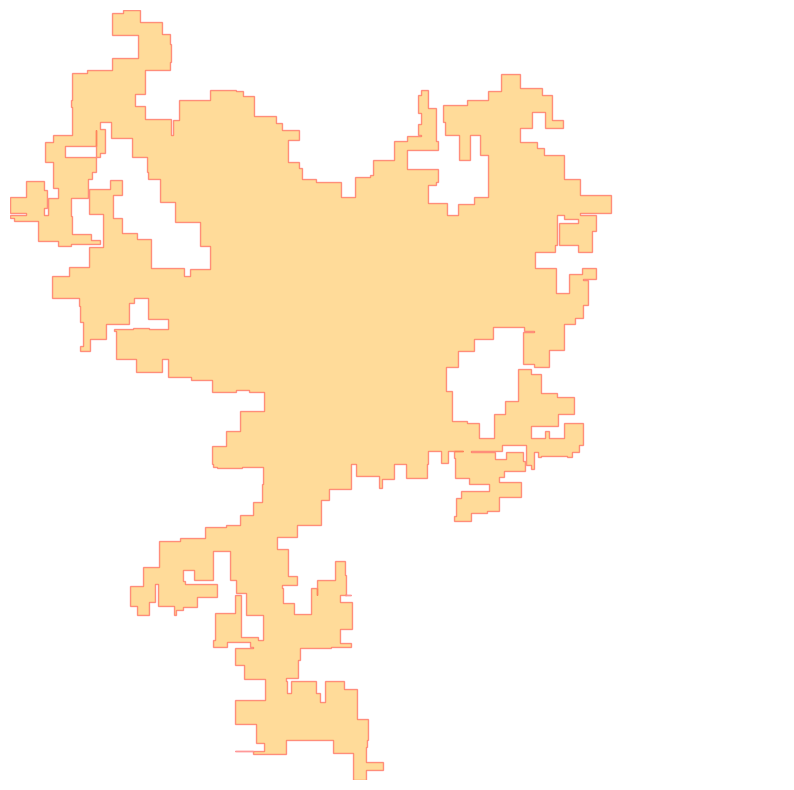

In [22]:
v = np.array(new_vertices)
mins = v.min(axis=0)
maxs = v.max(axis=0)
width = max(maxs - mins)

p = Polygon(v, facecolor = 'orange', alpha=0.4, edgecolor='r')

fig, ax = plt.subplots(figsize=(10, 10))
ax.add_patch(p)
ax.set_xlim([mins[0], mins[0] + width + 1])
ax.set_ylim([mins[1], mins[1] + width + 1])
ax.axis('off')
plt.show()

Extra reading:
- [Pick's theorem](https://en.wikipedia.org/wiki/Pick%27s_theorem)
- [Shoelace formula](https://en.wikipedia.org/wiki/Shoelace_formula)